## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import support as sp
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import pickle

## 1. Lectura del conjunto de datos

In [2]:
df_origen = pd.read_csv("diamonds.csv")
df = df_origen.copy()
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.shape

(53940, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
df.describe(include="object")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


## 2. Exploración y preprocesado

### 2.1. Exploración

#### 2.1.1. Variable respuesta

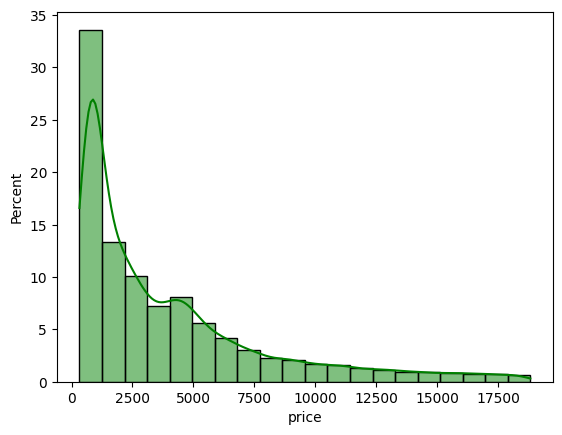

In [7]:
sns.histplot(df["price"], bins=20, stat="percent", kde=True, color="green");

#### 2.1.2. Variables numéricas

array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>],
       [<Axes: title={'center': 'table'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

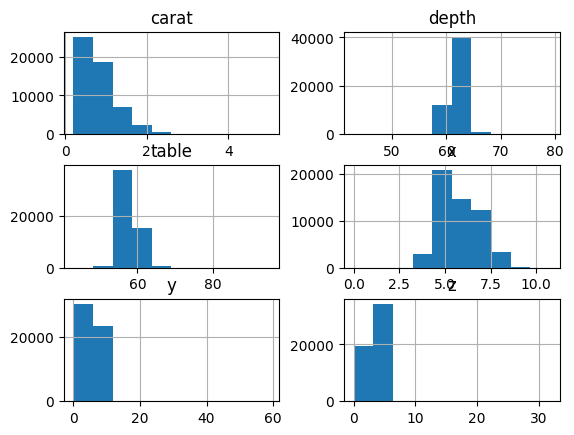

In [8]:
df.drop(["price", "Unnamed: 0"], axis=1).hist()

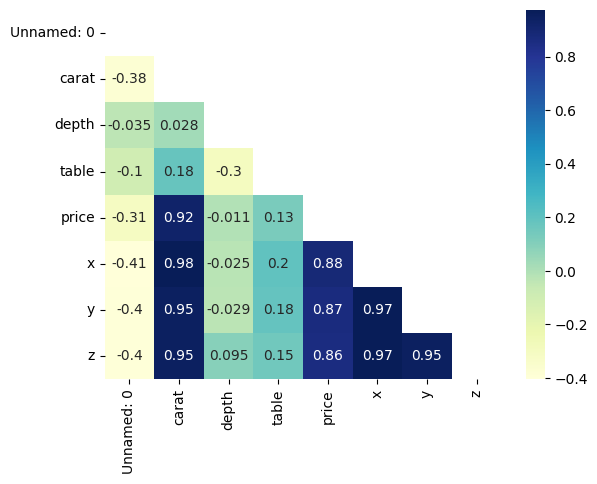

In [9]:
mask = np.triu(np.ones_like(df.select_dtypes(include=np.number).corr(), dtype = np.bool))
sns.heatmap(df.select_dtypes(include=np.number).corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

#### 2.1.3. Variables categóricas

In [10]:
df.describe(include="object")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


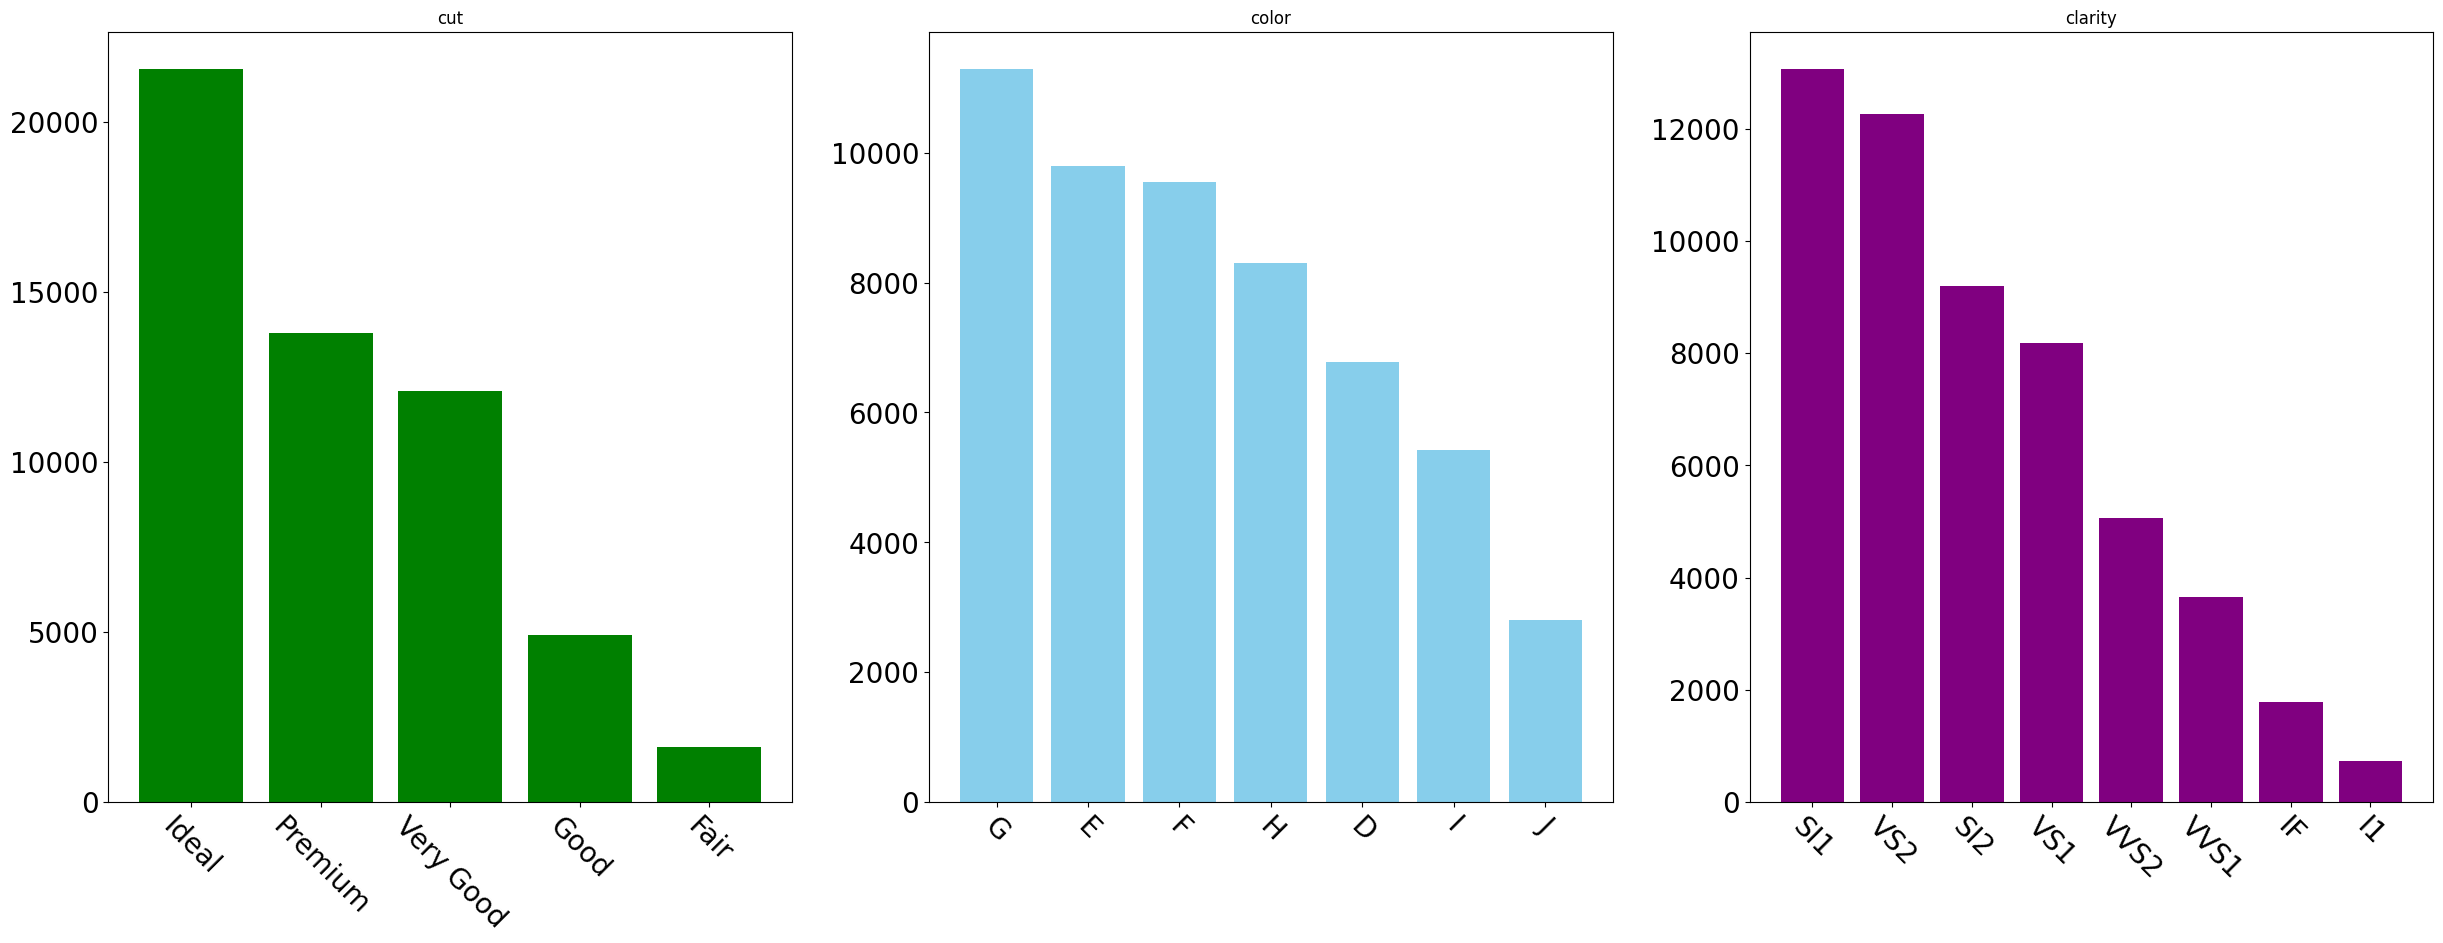

In [11]:
# Mostramos la distribución de las varaibles categóricas

sp.visual_categ(df.select_dtypes(include="object"))

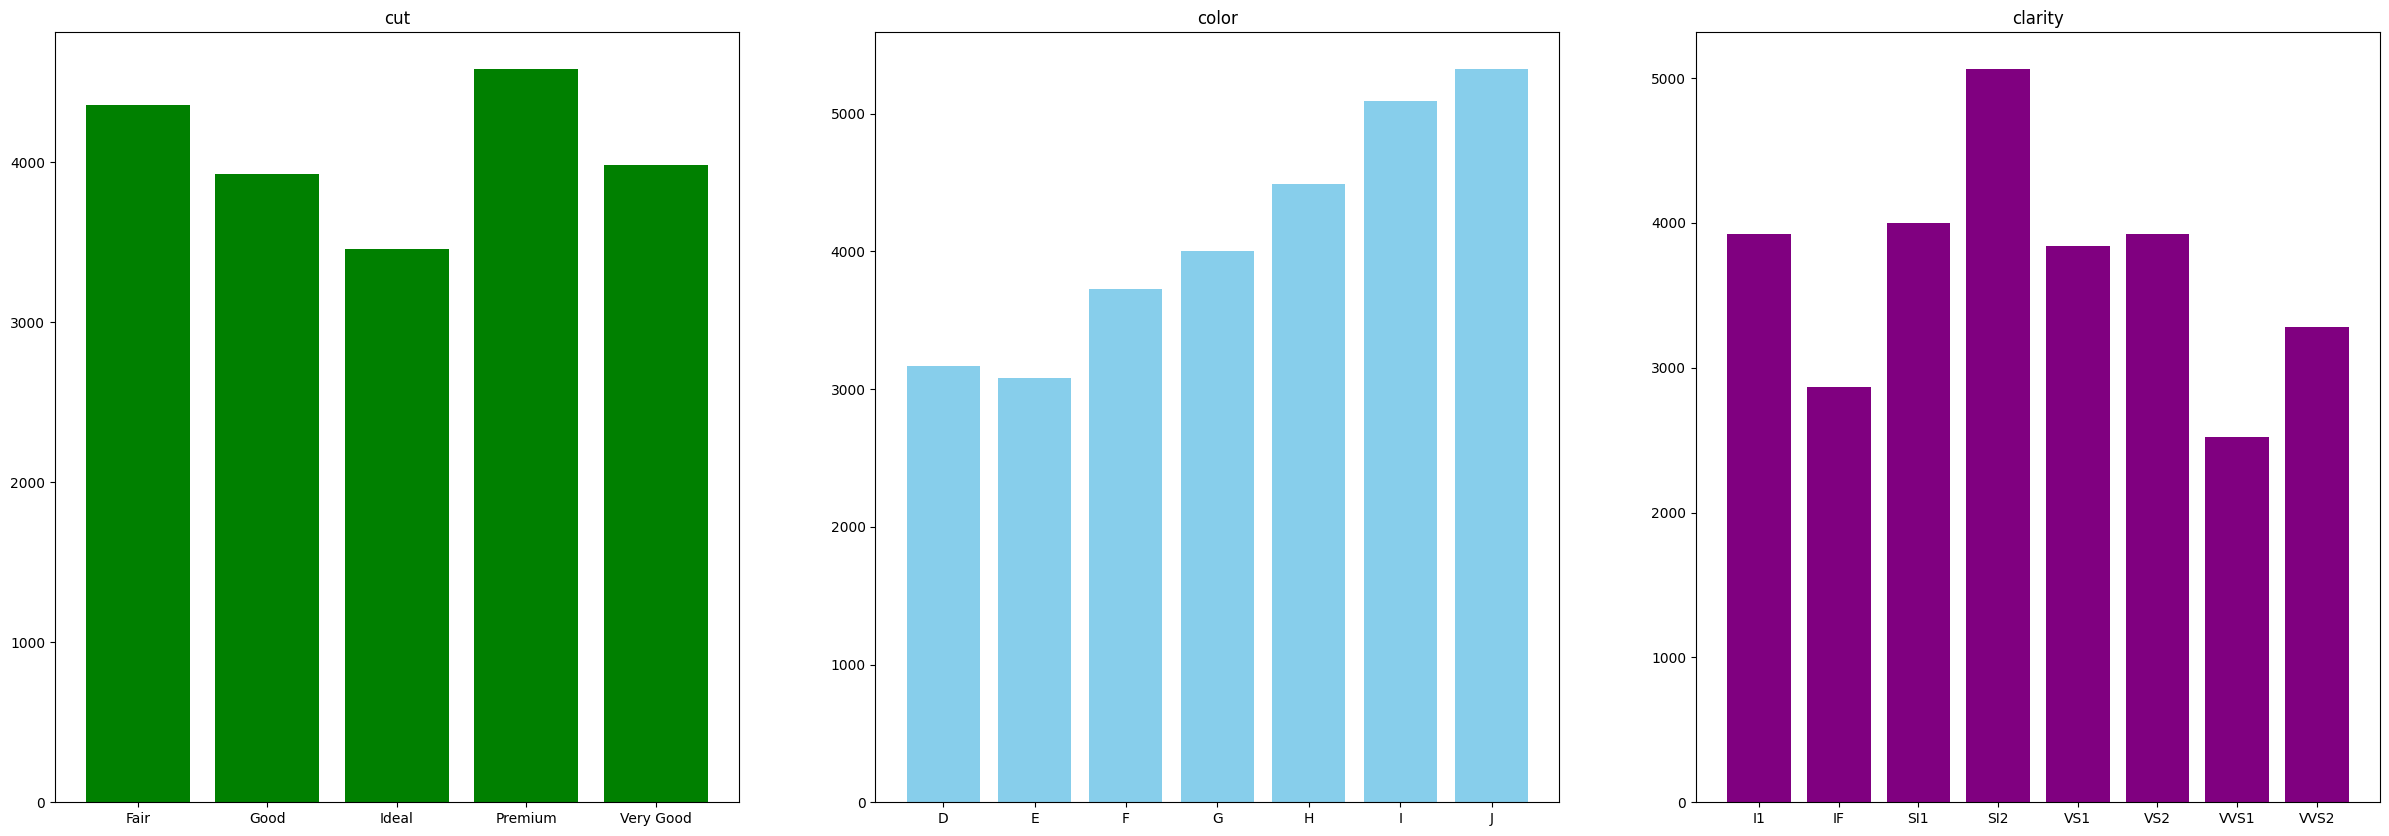

In [12]:
# Mostramos el promedio de precio para cada una de las variables de cada característica de entrada.

sp.mean_price_categ(df)

### 2.2. Preprocesado

In [13]:
# Eliminamos columna de índices

df = df.drop("Unnamed: 0", axis = 1)

In [14]:
# Eliminamos las características x, y, z por la alta correlación con el precio y carat.

df_reduced = df.drop(["x","y","z"], axis=1)

## 3. División del conjunto de datos

In [15]:
train_set, val_set, test_set = sp.train_val_test_split(df_reduced)
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 32364
Longitud del Validation Set: 10788
Longitud del Test Set: 10788


In [16]:
X_train, y_train = sp.remove_labels(train_set, "price")
X_val, y_val = sp.remove_labels(val_set, "price")
X_test, y_test = sp.remove_labels(test_set, "price")

## 4. Preparación del conjunto de datos

In [17]:
num_attribs = list(X_train.select_dtypes(exclude=['object']))
cat_attribs = list(X_train.select_dtypes(include=['object']))

In [18]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rbst_scaler", RobustScaler())
])


In [19]:
categories = [
    np.array(['Fair', 'Good','Very Good', 'Premium', 'Ideal']),
    np.array(['J', 'I', 'H', 'G', 'F', 'E', 'D']),
    np.array([ 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])]

In [20]:
cat_pipeline = Pipeline([("oh", OneHotEncoder())])

In [21]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [22]:
X_train_prep = full_pipeline.fit_transform(X_train)
X_train_prep = pd.DataFrame.sparse.from_spmatrix(X_train_prep, columns=list(pd.get_dummies(X_train).columns))

## 5. Entrenamiento del algoritmo

In [23]:
lin_reg = LinearRegression()

In [24]:
lin_reg.fit(X_train_prep, y_train)

LinearRegression()

In [25]:
lin_reg.intercept_

np.float64(2553.546743788602)

In [26]:
lin_reg.coef_

array([ 5684.39988541,   -31.47549302,   -82.56208728,  -616.7087299 ,
           8.51021772,   258.61303413,   182.94531663,   166.64016142,
         834.03484972,   602.0746957 ,   520.00377197,   302.69176244,
        -168.96932084,  -608.38402982, -1481.45172917, -3836.20637491,
        1649.7618454 ,  -224.00074324, -1156.81503533,   724.59569918,
         409.66723125,  1269.01579612,  1163.98158153])

In [27]:
lin_reg.feature_names_in_

array(['carat', 'depth', 'table', 'cut_Fair', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'], dtype=object)

## 6. Predicciones

In [28]:
X_val_prep = full_pipeline.transform(X_val)
X_val_prep = pd.DataFrame.sparse.from_spmatrix(X_val_prep, columns=list(pd.get_dummies(X_val).columns))

In [29]:
y_val_pred = lin_reg.predict(X_val_prep)

## 7. Evaluación de los resultados 

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_val_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_val_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))
print("R2:",  metrics.r2_score(y_val, y_val_pred))

Mean Absolute Error: 804.2198366439474
Mean Squared Error: 1343229.137563435
Root Mean Squared Error: 1158.9776259977734
R2: 0.9142271539988613


## 8. Visualización de los resultados

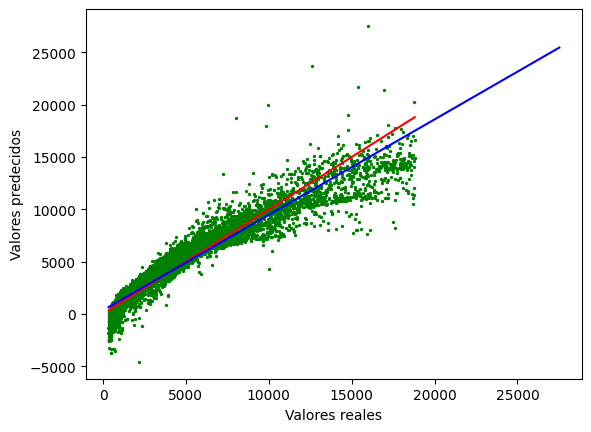

In [31]:
# Creamos un scatter plot para mostrar la precisión de los resultados.

plt.scatter(y_val, y_val_pred, color="green", edgecolors="face", s=2)
plt.xlabel("Valores reales")
plt.ylabel("Valores predecidos")

# la recta nos sirve para ver cuál es la tendencia de los resultados reales vs los predecidos.

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")

m, b = np.polyfit(y_val, y_val_pred, 1)

x = np.linspace(min(y_val), max(y_val_pred), 100)
y = m * x + b

# Esta recta muestra lo alejados que están los puntos de una predicción perfecta.

plt.plot(x, y, color='blue', label=f'Tendencia: y = {m:.2f}x + {b:.2f}')

## 9. Predicciones con el conjunto de pruebas

In [32]:
X_test_prep = full_pipeline.transform(X_test)
X_test_prep = pd.DataFrame.sparse.from_spmatrix(X_test_prep, columns=list(pd.get_dummies(X_test).columns))

In [33]:
y_test_pred = lin_reg.predict(X_test_prep)

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_val_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_val_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))
print("R2:",  metrics.r2_score(y_val, y_val_pred))

Mean Absolute Error: 804.2198366439474
Mean Squared Error: 1343229.137563435
Root Mean Squared Error: 1158.9776259977734
R2: 0.9142271539988613


## 10. Guardar el modelo creado

In [35]:
pickle.dump(lin_reg, open("modelo_regresion_lineal.sav", "wb"))

In [36]:
nuevo_modelo = pickle.load(open("modelo_regresion_lineal.sav", "rb"))

## 11. Otros modelos

### 11.1. Ridge Regression

In [37]:
ridge_reg =Ridge()

In [38]:
param_grid = {"alpha": [0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(ridge_reg, param_grid, cv=5,
                           scoring='r2')

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.01, 0.1, 1, 10]},
             scoring='r2')

In [39]:
grid_search.best_params_

{'alpha': 1}

In [40]:
best_ridge_reg = grid_search.best_estimator_

In [41]:
y_val_ridge = best_ridge_reg.predict(X_val_prep)

In [42]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_val_ridge))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_val_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_val_ridge)))
print("R2:",  metrics.r2_score(y_val, y_val_ridge))

Mean Absolute Error: 804.0368219087176
Mean Squared Error: 1343231.8546749768
Root Mean Squared Error: 1158.978798199077
R2: 0.9142269804957833


In [43]:
best_ridge_reg.score(X_val_prep, y_val)

0.9142269804957833

### 11.2. Lasso Regression

In [44]:
lasso_reg = LassoCV()

In [45]:
lasso_reg.fit(X_train_prep, y_train)

LassoCV()

In [46]:
y_train_lasso = lasso_reg.predict(X_train_prep)
y_val_lasso = lasso_reg.predict(X_val_prep)

In [ ]:
sp.overfit_model(y_train, y_train_lasso, y_val, y_val_lasso)

R^2 en entrenamiento: 0.9155740412131401
R^2 en validación: 0.9140802021826488


In [47]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_val_lasso))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_val_lasso))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_val_lasso)))
print("R2:",  metrics.r2_score(y_val, y_val_lasso))

Mean Absolute Error: 797.6500807650364
Mean Squared Error: 1345530.4481827884
Root Mean Squared Error: 1159.9700203810391
R2: 0.9140802021826488


### 11.2. Decision Tree

In [90]:
clf = DecisionTreeRegressor(max_depth=5)

In [91]:
clf.fit(X_train_prep, y_train)

DecisionTreeRegressor(max_depth=5)

In [93]:
y_train_tree = clf.predict(X_train_prep)
y_val_tree = clf.predict(X_val_prep)

In [94]:
sp.overfit_model(y_train, y_train_tree, y_val, y_val_tree)

# El modelo tiene overfitting

R^2 en entrenamiento: 0.9127550194935748
R^2 en validación: 0.9074484043464421


In [95]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_val_tree))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_val_tree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_val_tree)))
print("R2:",  metrics.r2_score(y_val, y_val_tree))

Mean Absolute Error: 656.0580734247029
Mean Squared Error: 1449386.4411144517
Root Mean Squared Error: 1203.9046644624532
R2: 0.9074484043464421


#### 11.2.2. Mostrando el límite de decisión - 2D

In [208]:
X_train_prep_reduced = X_train_prep[["carat", "table"]]

In [107]:
clf_reduced = DecisionTreeRegressor(max_depth=2)
clf_reduced.fit(X_train_prep_reduced, y_train)

DecisionTreeRegressor(max_depth=2)

c:\Users\User\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_16280\3145368228.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


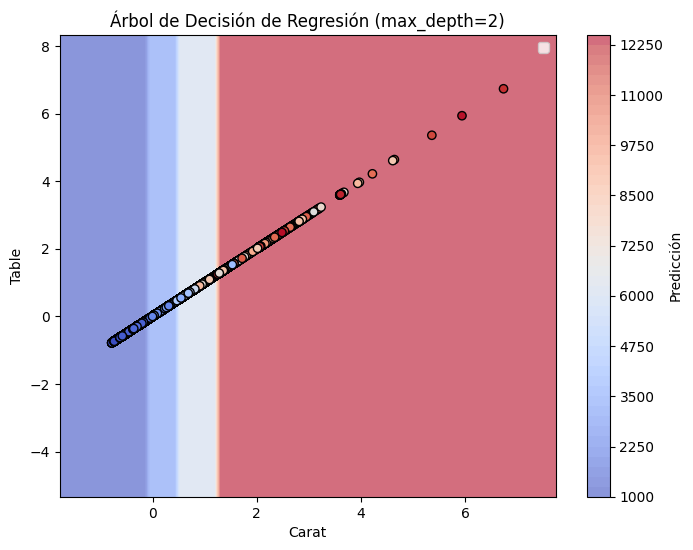

In [206]:
x1_range = np.linspace(X_train_prep_reduced["carat"].min() - 1, X_train_prep_reduced["carat"].max() + 1, 100)
x2_range = np.linspace(X_train_prep_reduced["table"].min() - 1, X_train_prep_reduced["table"].max() + 1, 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[xx1.ravel(), xx2.ravel()]
y_pred_reduced = clf_reduced.predict(grid_points).reshape(xx1.shape)

plt.figure(figsize=(8, 6))
countour = plt.contourf(xx1, xx2, y_pred, alpha=0.6, cmap="coolwarm", levels=50)
plt.colorbar(countour, label= "Predicción")
plt.title("Árbol de Decisión de Regresión (max_depth=2)")
plt.xlabel("Carat")
plt.ylabel("Table")
plt.legend()
plt.scatter(X_train_prep_reduced["carat"], X_train_prep_reduced["carat"], c=y_train, edgecolor='k', cmap="coolwarm", label="Puntos reales")
plt.show()

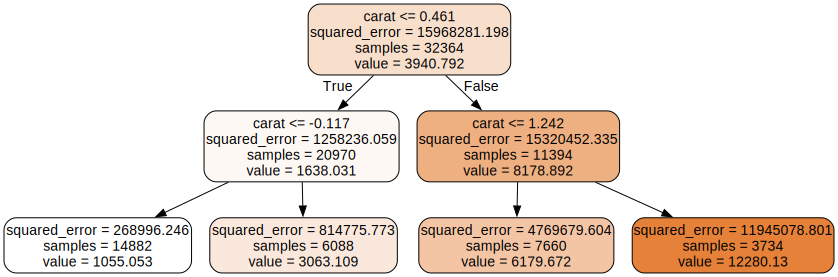

In [210]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        clf_reduced,
        out_file="android_malware.dot",
        feature_names=X_train_prep_reduced.columns,
        class_names=["benign", "adware", "malware"],
        rounded=True,
        filled=True
    )

Source.from_file("android_malware.dot")